# Final Report: Extracting Forest Areas from Google Maps Aerial Images


Global forest coverage has declined continuously since at least 1992 due to, for example, economic exploration of the rainforest. Reducing deforestation is an important contributor to climate change mitigation, the first step of which is effective monitoring of forest areas. The value of monitoring forest areas has been demonstrated in many contexts and various organizations invest in research projects to better map tree cover. For example, Global Forest Watch publicly share their global map of forest cover including tree gain and loss over time. Analysis based on this map can be used to detect and respond to illegal mining and deforestation activities, report on forest fires, or assess environmental risks of businesses.
This project aims to test different image processing approaches to extract forest areas from Google Maps aerial images.
For the purpose of this project, forests are defined as any visible tree-covered areas and are not restricted to primary forest. This definition will not be fitting for all purposes, and appropriate adjustments will have to be made in specific use cases. For example, I do not exclude agricultural tree plantations, such as soya farms. 


The following methods are used in this project:

1. Image Collection 
2. Feature Extraction
    * Color
    * Vegetation indices
    * Haralick descriptors of texture
3. Clustering
    * Thresholding
    * k-means
4. Classification
5. Labelling (Outline overlay)

The remainder of this report is organized as follows: Section A describes the approach in detail, using four sample images to demonstrate the different image processing techniques employed. Since the partial report already described color analysis and thresholding segmentation, this report focuses in more detail on the other approaches. Section B lists some limitations and section C presents the full pipeline applied to other images.

# A. Approach

## 1. Image Collection 
The images are sourced from the Google Maps static maps API, centered at randomly sampled locations within Sao Paulo state in Brazil. Collected images have size 512x512 pixels and zoom level 14. In the remainder of this section, the following four example images will serve as illustrations of the approaches used in this project. They are representative of the main landscape elements present in the examined region of Brazil.




In [2]:
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
from scipy import ndimage
from sklearn.metrics.pairwise import cosine_similarity
from os import listdir
import random

# color processing fcts:
from helper_functions import attributes_lum, attributes_reshape, chromatic_coords, RGB_normalizer
# vegetation indices
from helper_functions import veg_ind
# texture processing fcts:
from helper_functions import glcm_calculation, haralick_descriptors
# clustering fct:
from helper_functions import kmeans, RGB_seg
# outline and cleaning fct:
from helper_functions import outline_overlay


# read sample images in rgb
img1 = imageio.imread('images/lat-21.553191851763607_long -47.58674520014182_map.png')
img2 = imageio.imread('images/lat-22.284617723129536_long -48.18559920332148_map.png')
img3 = imageio.imread('images/lat-22.200495034324955_long -48.69176482972345_map.png')
img4 = imageio.imread('images/lat-22.871824828375946_long -48.449788736601434_map.png')

# preprocessing step: crop google logo region
img1 = img1[0:490,:,0:3]
img2 = img2[0:490,:,0:3]
img3 = img3[0:490,:,0:3]
img4 = img4[0:490,:,0:3]

# plot images
plt.figure(figsize=(20,5))
plt.subplot(141); plt.imshow(img1); plt.title('Image 1')
plt.subplot(142); plt.imshow(img2); plt.title('Image 2')
plt.subplot(143); plt.imshow(img3); plt.title('Image 3')
plt.subplot(144); plt.imshow(img4); plt.title('Image 4')

Text(0.5, 1.0, 'Image 4')

## 2. Feature Extraction

I extract three types of features to aid clustering: color features, vegetation indices, and texture descriptors.  

Together, these features will help differentiate the main landscape elements present in the images, which is not always trivial. Note for example the following subsets of images depicting tree cover, a river, agricultural fields, and urban areas. A key characteristic of forests is their dark green color, though it is not a sufficient criterion for classification: The river and forest areas have very similar colors. Adding texture will help differentiate these two plots due to the relatively smoother texture of the river. Yet texture can be misleading as well, since urban areas also have a varied texture, as can be seen in the grey-level images. Vegetation indices will help differentiate these urban and unplanted areas from planted fields and forests.



Text(0.5, 1.0, 'Urban (gray-level)')

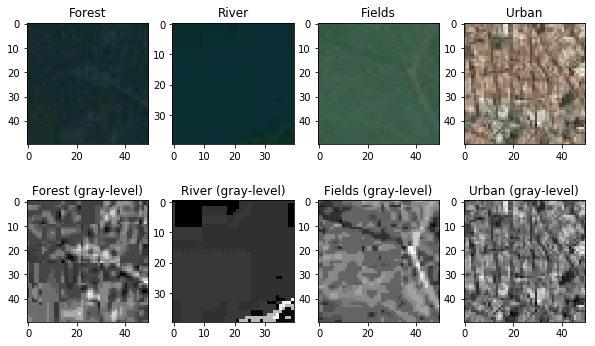

In [3]:
### key areas of interest
# a) forest window
forest_color = img1[160:210,60:110]
# b) river
river_color = img3[10:50,10:50]
# c) fields
fields_color = img3[200:250,50:100]
# d) urban area
urban_color = img4[200:250,200:250]

# convert images to greyscale for texture analysis using luminance
gray1 = attributes_lum(img1).reshape((img1.shape[0],img1.shape[1]))
gray2 = attributes_lum(img2).reshape((img2.shape[0],img1.shape[1]))
gray3 = attributes_lum(img3).reshape((img3.shape[0],img1.shape[1]))
gray4 = attributes_lum(img4).reshape((img4.shape[0],img1.shape[1]))

# a) forest window
forest = gray1[160:210,60:110]
# b) river
river = gray3[10:50,10:50]
# c) fields
fields = gray3[200:250,50:100]
# d) urban area
urban = gray4[200:250,200:250]

# plot windows
plt.figure(figsize=(10,6))
plt.subplot(241); plt.imshow(forest_color); plt.title('Forest')
plt.subplot(242); plt.imshow(river_color); plt.title('River')
plt.subplot(243); plt.imshow(fields_color); plt.title('Fields')
plt.subplot(244); plt.imshow(urban_color); plt.title('Urban')
plt.subplot(245); plt.imshow(forest, cmap='gray'); plt.title('Forest (gray-level)')
plt.subplot(246); plt.imshow(river, cmap='gray'); plt.title('River (gray-level)')
plt.subplot(247); plt.imshow(fields, cmap='gray'); plt.title('Fields (gray-level)')
plt.subplot(248); plt.imshow(urban, cmap='gray'); plt.title('Urban (gray-level)')

### 2.1 Color
For this analysis, I examine both RGB and HSV color channels. The histograms of the forest subimage show the expected values for tree-covered areas in each of the six color channels. The table below summarizes the average values in each color channel for each of the four landscape elements. This gives a glimpse of how color features may help distinguish the different regions of the satellite images, in order to extract forest areas.

Text(0.5, 1.0, 'Value')

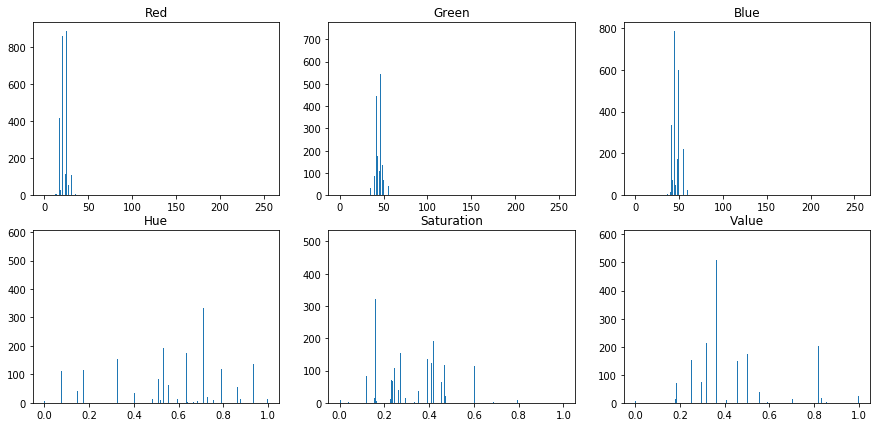

In [4]:
# convert to hsv
forest_hsv = rgb_to_hsv(RGB_normalizer(forest_color))
river_hsv = rgb_to_hsv(RGB_normalizer(river_color))
fields_hsv = rgb_to_hsv(RGB_normalizer(fields_color))
urban_hsv = rgb_to_hsv(RGB_normalizer(urban_color))


## Histograms
plt.figure(figsize=(15,7))
plt.subplot(231); plt.hist(forest_color[:,:,0].ravel(), bins=256, range=(0,255)); plt.title('Red')
plt.subplot(232); plt.hist(forest_color[:,:,1].ravel(), bins=256, range=(0,255)); plt.title('Green')
plt.subplot(233); plt.hist(forest_color[:,:,2].ravel(), bins=256, range=(0,255)); plt.title('Blue')
plt.subplot(234); plt.hist(forest_hsv[:,:,0].ravel(), bins=256, range=(0,1)); plt.title('Hue')
plt.subplot(235); plt.hist(forest_hsv[:,:,1].ravel(), bins=256, range=(0,1)); plt.title('Saturation')
plt.subplot(236); plt.hist(forest_hsv[:,:,2].ravel(), bins=256, range=(0,1)); plt.title('Value')

In [5]:
# table summarizing averages by river, forest, etc.
rgb_all = pd.DataFrame([np.mean(forest_color, axis=(0,1)),
                       np.mean(river_color, axis=(0,1)),
                       np.mean(fields_color, axis=(0,1)),
                       np.mean(urban_color, axis=(0,1))]).round(1)
hsv_all = pd.DataFrame([np.mean(forest_hsv, axis=(0,1)),
                       np.mean(river_hsv, axis=(0,1)),
                       np.mean(fields_hsv, axis=(0,1)),
                       np.mean(urban_hsv, axis=(0,1))]).round(2)
col_all = pd.concat((rgb_all, hsv_all), axis=1)
col_all.columns = ['R', 'G', 'B', 'H', 'S', 'V']
col_all.index = ['Forest', 'River', 'Fields', 'Urban']
col_all

,R,G,B,H,S,V
Forest,22.1,43.7,46.5,0.59,0.33,0.47
River,10.3,44.4,47.9,0.61,0.99,0.70
Fields,60.6,93.2,74.0,0.54,0.44,0.57
Urban,143.8,127.5,111.7,0.36,0.19,0.51


### 2.2 Vegetation Indices
Vegetation indices are transformations of color channels to highlight vegetation in images.

Following the example in (Torres-Sanchez et al, 2014), 

I use the following four different vegetation indices (Woebbecke et al, 1995; Kataoka et al, 2003) commonly implemented in the literature (for example in (Torres-Sanchez et al, 2014)):
* Color Index of Vegetation (CIVE)
$$CIVE = 0.441r - 0.881g + 0.385b + 18.78745$$
* Woebbecke Index
$$WI = \frac{g-b}{r-g}$$
* Excess Green (ExG)
$$ExG = 2g-r-b$$
* Excess Green minus Excess Red (ExGR)
$$ExGR = ExG-1.4r-g$$

where chromatic coordinates of RGB channels are defined as follows:
$$r = \frac{R}{R+G+B}$$

$$g = \frac{G}{R+G+B}$$

$$b = \frac{R}{R+G+B}$$

The table below summarizes the average vegetation indices for the sample forest, river, fields, and urban subimages. While the indices are very similar for the average field and forest pixel, it is clear that these indices will help distinguish river and urban areas.

In [6]:
# compute vegetation indices for each of the windows:
# forest
veg_forest = veg_ind(forest_color, colorsch='rgb')
veg_forest = attributes_reshape(veg_forest)
# river
veg_river = veg_ind(river_color, colorsch='rgb')
veg_river = attributes_reshape(veg_river)
# fields
veg_fields = veg_ind(fields_color, colorsch='rgb')
veg_fields = attributes_reshape(veg_fields)
# urban
veg_urban = veg_ind(urban_color, colorsch='rgb')
veg_urban = attributes_reshape(veg_urban)

# table summarizing averages by river, forest, etc.
veg_all = pd.DataFrame([np.mean(veg_forest, axis=0), 
                        np.mean(veg_river, axis=0), 
                        np.mean(veg_fields, axis=0),
                        np.mean(veg_urban, axis=0)]).round(2)
veg_all.columns = ['CIVE', 'WI', 'ExG', 'ExGR']
veg_all.index = ['Forest', 'River', 'Fields', 'Urban']
veg_all

,CIVE,WI,ExG,ExGR
Forest,18.80,-0.47,-0.06,-0.20
River,18.92,-2.89,-0.39,-0.25
Fields,18.73,-0.38,0.09,0.12
Urban,18.80,-0.01,-0.07,-0.30


### 2.3 Texture 
To describe texture in the satellite images, I generate Haralick descriptors (Haralick et al, 1973) from the Grey-level Co-occurance Matrices (GLCM) of the neighborhood around each pixel using a sliding window. The RGB images are converted to grey-level using luminance, which has been shown to be an effective conversion approach for use with Haralick descriptors (Ponti et al, 2016). The sliding window size was chosen as 7x7 pixels, which has been shown to be appropriate for vegetation detection (Giannini et al, 2012). Computing the descriptors separately for each pixel is less efficient applying the same value to all pixels in the window, yet it will help better characterize pixels at border segments.

I use the following Haralick descriptors:

$$Maximum Probability = max_{i,j}(p_{ij}) $$
$$Correlation = \sum_{i=1}^{K} \sum_{j=1}^{K} \frac{(i-m_{r})(j-m_{c})}{v_{r}v_{c}}$$
$$Contrast = \sum_{i=1}^{K} \sum_{j=1}^{K} (i-j)^2 p_{ij} $$
$$Energy = \sum_{i=1}^{K} \sum_{j=1}^{K} (p_{ij})^2 $$
$$Homogeneity = \sum_{i=1}^{K} \sum_{j=1}^{K} \frac{p_{ij}}{1+|i-j|} $$
$$Entropy = - \sum_{i=1}^{K} \sum_{j=1}^{K} p_{ij} log_{2}p_{ij}$$

where 
$$m_{r} = \sum_{i=1}^{K} i \sum_{j=1}^{K} p_{ij} $$
$$m_{c} = \sum_{j=1}^{K} j \sum_{i=1}^{K} p_{ij}$$
$$v_{r} = \sum_{i=1}^{K} (i-m_{r})^2 \sum_{j=1}^{K} p_{ij}$$
$$v_{c} = \sum_{j=1}^{K} (j-m_{c})^2 \sum_{i=1}^{K} p_{ij}$$

and where the elements of the probability matrix $p_{ij}$ are defined from the elements of GLCM $g_{ij}$ and the sum of the elements of GLCM $n$:

$$p_{ij} = \frac{g_{ij}}{n}$$
$$n = \sum_{j=1}^{K} \sum_{i=1}^{K} g_{ij}$$

$K$ is the number of gray levels.


Text(0.5, 1.0, 'Urban 1,1')

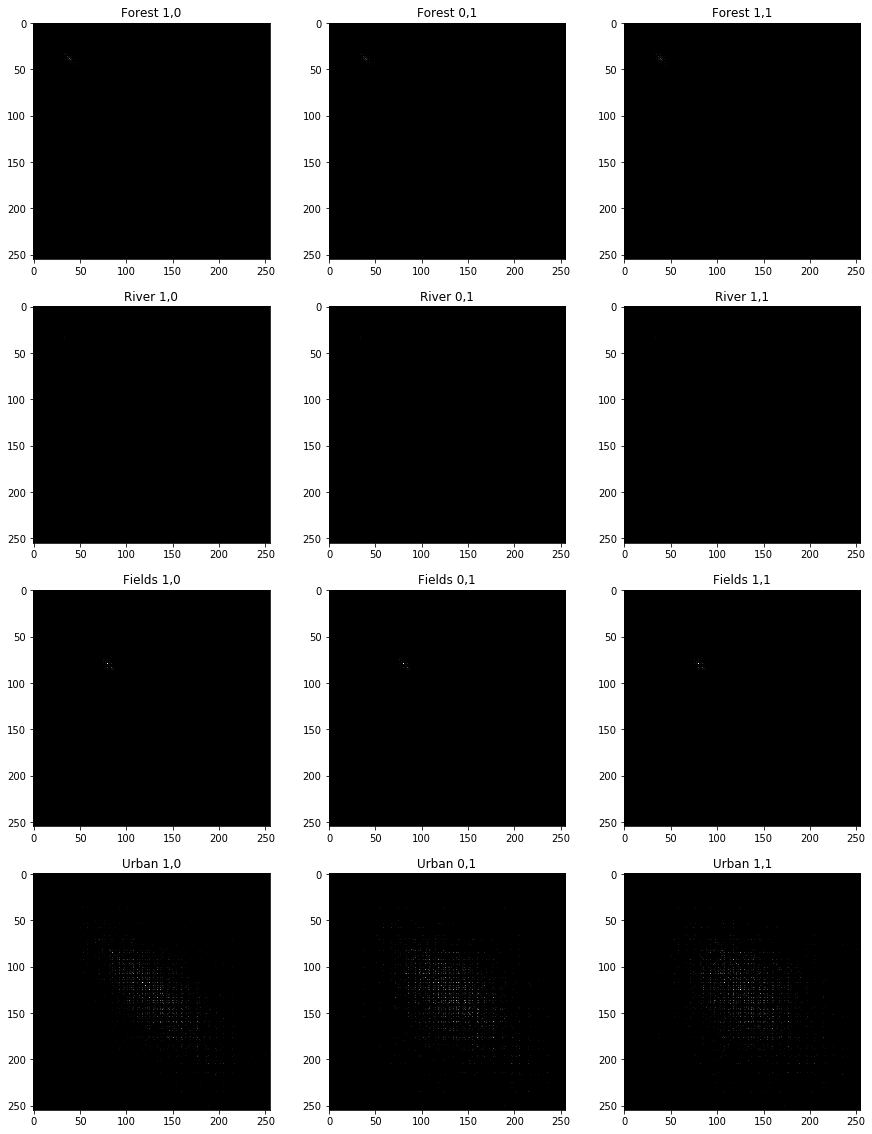

In [7]:
glcm_forest1 = glcm_calculation(forest, 1, 0)
glcm_forest2 = glcm_calculation(forest, 0, 1)
glcm_forest3 = glcm_calculation(forest, 1, 1)

glcm_river1 = glcm_calculation(river, 1, 0)
glcm_river2 = glcm_calculation(river, 0, 1)
glcm_river3 = glcm_calculation(river, 1, 1)

glcm_fields1 = glcm_calculation(fields, 1, 0)
glcm_fields2 = glcm_calculation(fields, 0, 1)
glcm_fields3 = glcm_calculation(fields, 1, 1)

glcm_urban1 = glcm_calculation(urban, 1, 0)
glcm_urban2 = glcm_calculation(urban, 0, 1)
glcm_urban3 = glcm_calculation(urban, 1, 1)

# plot co-occurance matrices
plt.figure(figsize=(15,20))
plt.subplot(431); plt.imshow(glcm_forest1, cmap='gray'); plt.title('Forest 1,0')
plt.subplot(432); plt.imshow(glcm_forest2, cmap='gray'); plt.title('Forest 0,1')
plt.subplot(433); plt.imshow(glcm_forest3, cmap='gray'); plt.title('Forest 1,1')

plt.subplot(434); plt.imshow(glcm_river1, cmap='gray'); plt.title('River 1,0')
plt.subplot(435); plt.imshow(glcm_river2, cmap='gray'); plt.title('River 0,1')
plt.subplot(436); plt.imshow(glcm_river3, cmap='gray'); plt.title('River 1,1')

plt.subplot(437); plt.imshow(glcm_fields1, cmap='gray'); plt.title('Fields 1,0')
plt.subplot(438); plt.imshow(glcm_fields2, cmap='gray'); plt.title('Fields 0,1')
plt.subplot(439); plt.imshow(glcm_fields3, cmap='gray'); plt.title('Fields 1,1')

plt.subplot(4,3,10); plt.imshow(glcm_urban1, cmap='gray'); plt.title('Urban 1,0')
plt.subplot(4,3,11); plt.imshow(glcm_urban2, cmap='gray'); plt.title('Urban 0,1')
plt.subplot(4,3,12); plt.imshow(glcm_urban3, cmap='gray'); plt.title('Urban 1,1')

In [8]:
# compute average of haralick descriptors of three reference pixels
haralick_forest = (haralick_descriptors(glcm_forest1) +
                   haralick_descriptors(glcm_forest2) +
                   haralick_descriptors(glcm_forest3)) / 3
    
haralick_river = (haralick_descriptors(glcm_river1) +
                  haralick_descriptors(glcm_river2) +
                  haralick_descriptors(glcm_river3)) / 3
    
haralick_fields = (haralick_descriptors(glcm_fields1) +
                   haralick_descriptors(glcm_fields2) +
                   haralick_descriptors(glcm_fields3)) / 3
    
haralick_urban = (haralick_descriptors(glcm_urban1) +
                  haralick_descriptors(glcm_urban2) +
                  haralick_descriptors(glcm_urban3)) / 3
# combine and print
haralick_all = pd.DataFrame([haralick_forest, haralick_river, haralick_fields, haralick_urban]).round(2)
haralick_all.columns = ['Max Prob', 'Correlation', 'Contrast', 'Energy', 'Homogeneity', 'Entropy']
haralick_all.index = ['Forest', 'River', 'Fields', 'Urban']
haralick_all

,Max Prob,Correlation,Contrast,Energy,Homogeneity,Entropy
Forest,0.19,0.67,7.51,0.05,0.60,5.53
River,0.85,0.53,0.81,0.73,0.96,0.96
Fields,0.29,0.70,6.54,0.11,0.66,4.77
Urban,0.01,0.49,1104.55,0.00,0.13,10.15


## 3. Clustering
After feature generation, the first step is segmenting images into separate regions, one or more of which encompass forest-covered areas. 

### 3.1 Thresholding
As presented in the partial report, I first tried simple thresholding methods to segment the image into forest and non-forest regions. I used thresholds based on color (in the RGB and HSV color channels) and vegetation indices. This approach gives mixed results depending on the input image. 



As the histograms in section 2.1 show, the RGB channels have clear spikes for the sample forest area. As a simple baseline for clustering, I use these RGB spikes to define a threshold range for segmentation into two clusters. Using the histogram counts, the following ranges are set for each channel:
* Red: 10 - 40 
* Green: 30 - 55 
* Blue: 35 - 60
    

Text(0.5, 1.0, 'RGB Segmentation, Image 4')

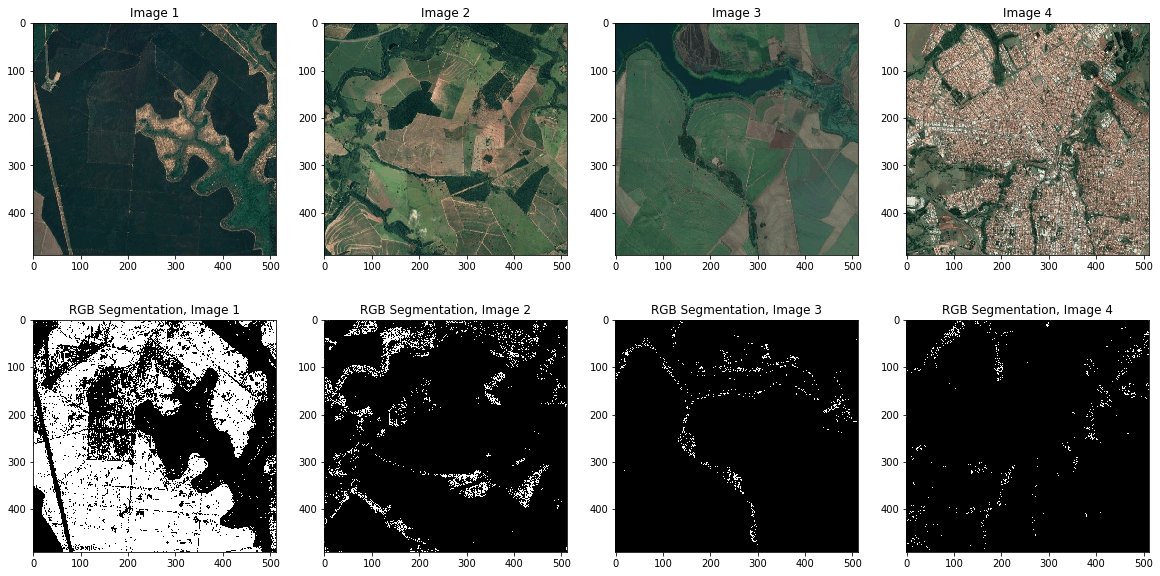

In [9]:
rgb_seg1 = RGB_seg(img1, normalized=False)
rgb_seg2 = RGB_seg(img2, normalized=False)
rgb_seg3 = RGB_seg(img3, normalized=False)
rgb_seg4 = RGB_seg(img4, normalized=False)


plt.figure(figsize=(20,10))
plt.subplot(241); plt.imshow(img1); plt.title('Image 1')
plt.subplot(242); plt.imshow(img2); plt.title('Image 2')
plt.subplot(243); plt.imshow(img3); plt.title('Image 3')
plt.subplot(244); plt.imshow(img4); plt.title('Image 4')
plt.subplot(245); plt.imshow(rgb_seg1, cmap='gray'); plt.title('RGB Segmentation, Image 1')
plt.subplot(246); plt.imshow(rgb_seg2, cmap='gray'); plt.title('RGB Segmentation, Image 2')
plt.subplot(247); plt.imshow(rgb_seg3, cmap='gray'); plt.title('RGB Segmentation, Image 3')
plt.subplot(248); plt.imshow(rgb_seg4, cmap='gray'); plt.title('RGB Segmentation, Image 4')

### 3.2 k-means clustering
The k-means clustering algorithm assigns pixels to a pre-defined number k of clusters based on the Euclidean distance from cluster centroids. Centroids are initialized randomly and then updated iteratively to reduce the within-cluster and simultaneously maximize the across-cluster variation (Sebestyen, 1962; MacQueen, 1967).

I tried different values of k=(2,3,4,5). The ultimate goal is to have two separate segments (forest areas and everything else). But given that there are 5 main different types of regions (forest, city, fields, water, urban), I try higher values of k, to avoid misclassifying fields as forests, for example, since they are relatively more similar than fields and cities. In this application, clustering is successful if tree-covered areas are separated from other areas, regardless of the number of clusters assigned to forest and non-forest areas. Using the four sample images, the best results were achieved for k=4. 

To avoid skewing distances due to different units across input variables, it is common practice to standardize features before implementing the k-means algorithm. In the code below, I compare clustering results using the raw input data, standardized features to 0 mean and 1 standard deviation, and data scaled to range 0-1.  

While each feature was examined individually in the sections above, the code below generates a dataset of all features (color, vegetation, texture) for each of the four sample images. Please note that I use pre-computed arrays of haralick descriptors for efficiency. The code for the window-sliding computation of haralick features can be found in a separate data file in the repository.

Text(0.5, 1.0, 'Scaled Features')

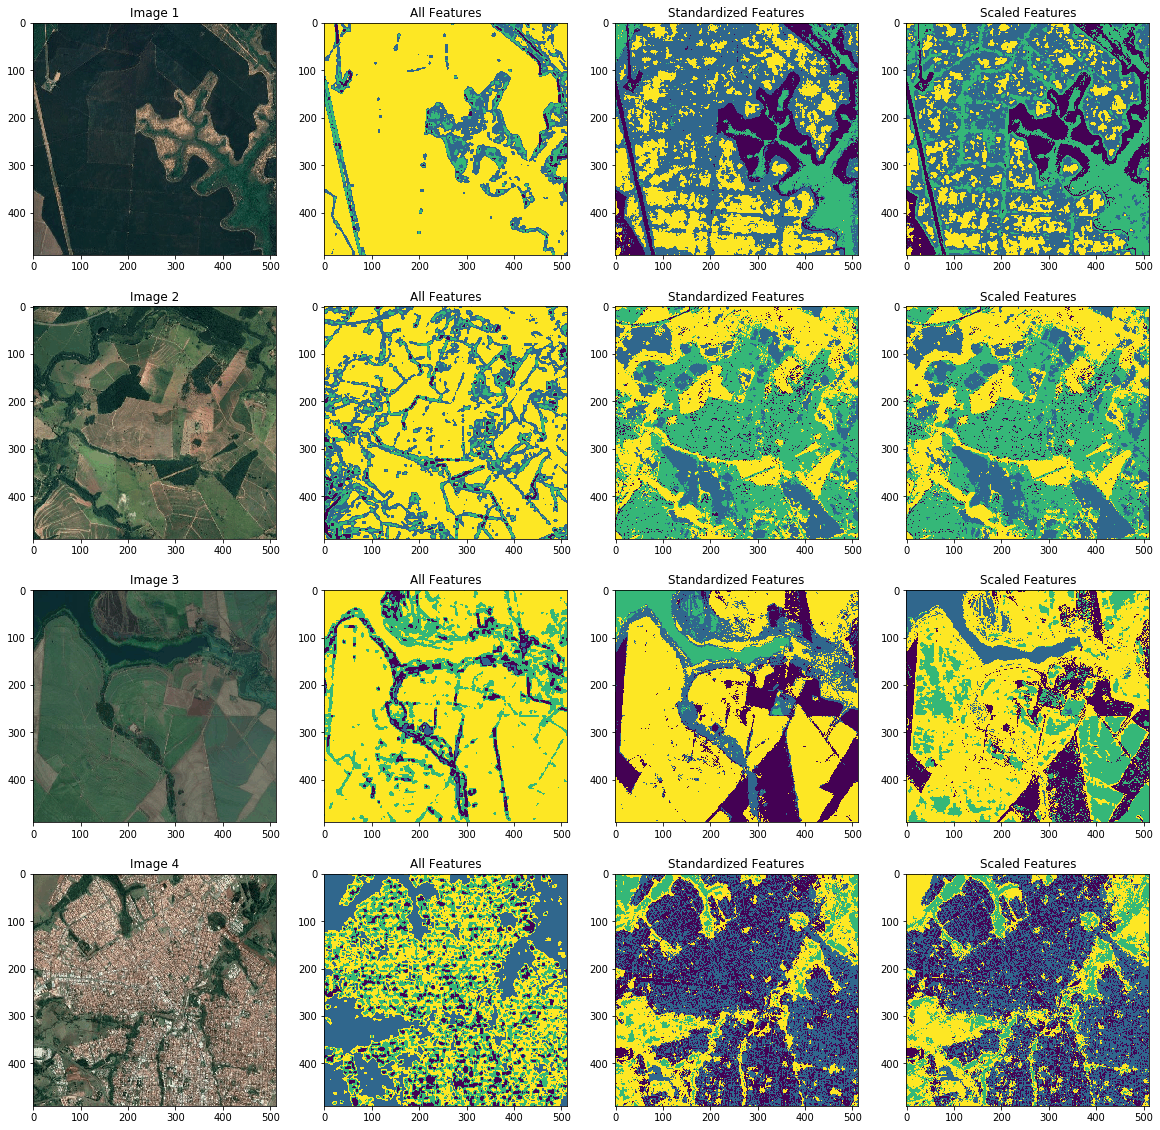

In [10]:
def generate_features(img, haralick_file):
    # Prepare data with all features
    img_features = np.zeros((img.shape[0]*img.shape[1], 4+6+5))
    # vegetation features
    img_features[:,0:4] = attributes_reshape(veg_ind(img, colorsch='rgb'))
    # color features
    img_features[:,4:7] = attributes_reshape(RGB_normalizer(img))  # RGB
    img_features[:,7:10] = attributes_reshape(rgb_to_hsv((RGB_normalizer(img))))
    # haralick descriptors
    haralick1 = np.load(haralick_file)
    haralick1_flat = np.reshape(haralick1, 
                                (haralick1.shape[0]*haralick1.shape[1], 
                                 haralick1.shape[2]))
    img_features[:,10:15] = haralick1_flat

    return(img_features)


# generate datasets for images 1-4
img1_features = generate_features(img1, 'haralick1.npy')
img2_features = generate_features(img2, 'haralick2.npy')
img3_features = generate_features(img3, 'haralick3.npy')
img4_features = generate_features(img4, 'haralick4.npy')

# standardization & scaling
# image 1
std_img1_features = (img1_features - np.mean(img1_features, axis=0))/np.std(img1_features, axis=0)
scaled_img1_features = (img1_features - img1_features.min(axis=0))/(img1_features.max(axis=0) - 
                                                                    img1_features.min(axis=0))
# image 2
std_img2_features = (img2_features - np.mean(img2_features, axis=0))/np.std(img2_features, axis=0)
scaled_img2_features = (img2_features - img2_features.min(axis=0))/(img2_features.max(axis=0) - 
                                                                    img2_features.min(axis=0))
# image 3
std_img3_features = (img3_features - np.mean(img3_features, axis=0))/np.std(img3_features, axis=0)
scaled_img3_features = (img3_features - img3_features.min(axis=0))/(img3_features.max(axis=0) - 
                                                                    img3_features.min(axis=0))
# image 4
std_img4_features = (img4_features - np.mean(img4_features, axis=0))/np.std(img4_features, axis=0)
scaled_img4_features = (img4_features - img4_features.min(axis=0))/(img4_features.max(axis=0) - 
                                                                    img4_features.min(axis=0))

# select different combinations of features for clustering
# all data
clusters_all_1 = kmeans(img1_features, k=4, S=12, n_iterations=100).reshape((img1.shape[0], img1.shape[1]))
clusters_all_2 = kmeans(img2_features, k=4, S=12, n_iterations=100).reshape((img2.shape[0], img2.shape[1]))
clusters_all_3 = kmeans(img3_features, k=4, S=12, n_iterations=100).reshape((img3.shape[0], img3.shape[1]))
clusters_all_4 = kmeans(img4_features, k=4, S=12, n_iterations=100).reshape((img4.shape[0], img4.shape[1]))
# standardized
clusters_std_1 = kmeans(std_img1_features, k=4, S=12, n_iterations=100).reshape((img1.shape[0], img1.shape[1]))
clusters_std_2 = kmeans(std_img2_features, k=4, S=12, n_iterations=100).reshape((img2.shape[0], img2.shape[1]))
clusters_std_3 = kmeans(std_img3_features, k=4, S=12, n_iterations=100).reshape((img3.shape[0], img3.shape[1]))
clusters_std_4 = kmeans(std_img4_features, k=4, S=12, n_iterations=100).reshape((img4.shape[0], img4.shape[1]))
# scaled
clusters_scaled_1 = kmeans(scaled_img1_features, k=4, S=12, n_iterations=100).reshape((img1.shape[0], img1.shape[1]))
clusters_scaled_2 = kmeans(scaled_img2_features, k=4, S=12, n_iterations=100).reshape((img2.shape[0], img2.shape[1]))
clusters_scaled_3 = kmeans(scaled_img3_features, k=4, S=12, n_iterations=100).reshape((img3.shape[0], img3.shape[1]))
clusters_scaled_4 = kmeans(scaled_img4_features, k=4, S=12, n_iterations=100).reshape((img4.shape[0], img4.shape[1]))


# plot:
plt.figure(figsize=(20,20))
# image 1
plt.subplot(441); plt.imshow(img1); plt.title('Image 1')
plt.subplot(442); plt.imshow(clusters_all_1); plt.title('All Features')
plt.subplot(443); plt.imshow(clusters_std_1); plt.title('Standardized Features')
plt.subplot(444); plt.imshow(clusters_scaled_1); plt.title('Scaled Features')
# image 2
plt.subplot(445); plt.imshow(img2); plt.title('Image 2')
plt.subplot(446); plt.imshow(clusters_all_2); plt.title('All Features')
plt.subplot(447); plt.imshow(clusters_std_2); plt.title('Standardized Features')
plt.subplot(448); plt.imshow(clusters_scaled_2); plt.title('Scaled Features')
# image 3
plt.subplot(449); plt.imshow(img3); plt.title('Image 3')
plt.subplot(4,4,10); plt.imshow(clusters_all_3); plt.title('All Features')
plt.subplot(4,4,11); plt.imshow(clusters_std_3); plt.title('Standardized Features')
plt.subplot(4,4,12); plt.imshow(clusters_scaled_3); plt.title('Scaled Features')
# image 4
plt.subplot(4,4,13); plt.imshow(img4); plt.title('Image 4')
plt.subplot(4,4,14); plt.imshow(clusters_all_4); plt.title('All Features')
plt.subplot(4,4,15); plt.imshow(clusters_std_4); plt.title('Standardized Features')
plt.subplot(4,4,16); plt.imshow(clusters_scaled_4); plt.title('Scaled Features')

Raw data performs poorly for all images. For example, it cannot differentiate between forest and fields in images 1 and 2.
Scaled data both performs reasonably well, especially for image 4, where it has the best performance of the three datasets. But it misclassifies some of the forest area in image 1, and it is unable to pick out the forest regions lining the river in image 3.
Standardized data gives the best results for our sample images. It groups some fields with forests in images 4 and 3, but largely groups forest pixels together correctly. This becomes evident, when plotting just the forest clusters identified in this segmentation:

Text(0.5, 1.0, 'Image 4, Cluster 3')

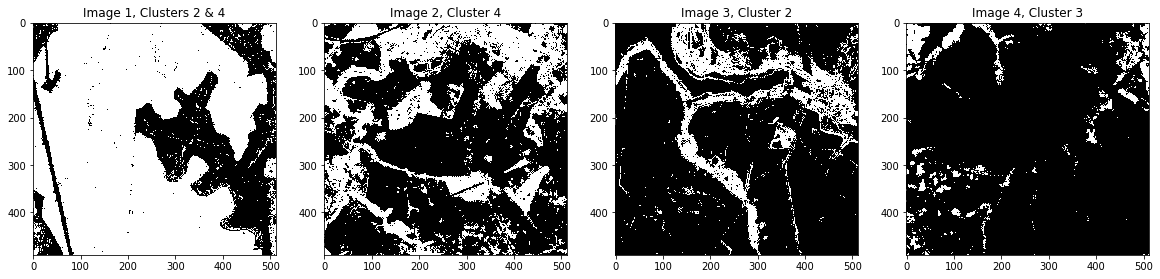

In [11]:
selected_clusters1 = ((clusters_std_1==4) | (clusters_std_1==2)).astype(int)
selected_clusters2 = (clusters_std_2==4).astype(int)
selected_clusters3 = (clusters_std_3==2).astype(int)
selected_clusters4 = (clusters_std_4==3).astype(int)

plt.figure(figsize=(20,5))
plt.subplot(141); plt.imshow(selected_clusters1, cmap='gray'); plt.title('Image 1, Clusters 2 & 4')
plt.subplot(142); plt.imshow(selected_clusters2, cmap='gray'); plt.title('Image 2, Cluster 4')
plt.subplot(143); plt.imshow(selected_clusters3, cmap='gray'); plt.title('Image 3, Cluster 2')
plt.subplot(144); plt.imshow(selected_clusters4, cmap='gray'); plt.title('Image 4, Cluster 3')


Further processing these images (cleaning and outline generation are discussed more in section 5 below) gives very good results, even though some small sporadic regions remain (e.g. images 2 and 3). For tasks with few images, manually selecting the relevant clusters enables good extraction of forest areas, as can be seen in the output images below. 


This segmentation result enables a broad range of applications. For example, we can determine the share of forest area of a given region, as is done for each of the four images in the table below.


The next section tests approaches to automatically classify clusters as forest or non-forest areas.

Text(0.5, 1.0, 'Image 4')

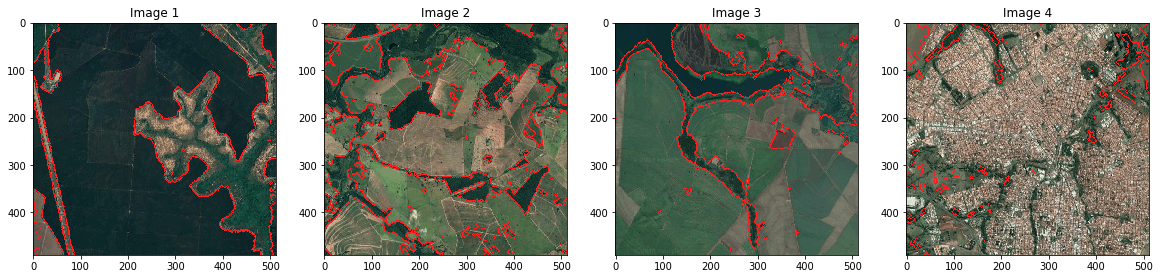

In [12]:
# plot images with outline (outline function explained in more detail below)
plt.figure(figsize=(20,5))
plt.subplot(141);plt.imshow(outline_overlay(selected_clusters1, img1)); plt.title('Image 1')
plt.subplot(142);plt.imshow(outline_overlay(selected_clusters2, img2)); plt.title('Image 2')
plt.subplot(143);plt.imshow(outline_overlay(selected_clusters3, img3)); plt.title('Image 3')
plt.subplot(144);plt.imshow(outline_overlay(selected_clusters4, img4)); plt.title('Image 4')

In [13]:
# compute share of forest area:
shares = pd.DataFrame([[np.sum(selected_clusters1) / (img1.shape[0]*img1.shape[1])],
                      [np.sum(selected_clusters2) / (img2.shape[0]*img2.shape[1])],
                      [np.sum(selected_clusters3) / (img3.shape[0]*img3.shape[1])],
                      [np.sum(selected_clusters4) / (img4.shape[0]*img4.shape[1])]]).round(2)
shares.columns = ['Forest share']
shares.index = ['Image 1', 'Image 2','Image 3','Image 4']
shares

,Forest share
Image 1,0.74
Image 2,0.34
Image 3,0.17
Image 4,0.07


## 4. Classification
This section tests methods to binarily classify clusters as forest or non-forest areas, in order to automatically detect forest areas in images at scale. 

I compute the cosine similarity between the median features of each cluster and the average forest features. The average forest features are computed using the median features of each of the manually classified clusters of the four images (see above: clusters 2&4 of image 1, cluster 4 of image 2, cluster 2 of image 3, and cluster 3 of image 4). In this way, the manual cluster classification serves to create a labelled dataset for automatic classification. Each cluster in each image is classified as forest area if their cosine similarity is above a set threshold. I implement this cosine classification for both standardized and raw data.

There are two key problems with this approach: (i) The clusters include some erroneously clustered pixels, which results in an imperfect measure for the average forest pixel. (ii) The features are standardized separately for each image, resulting in varied values for each of the forest vectors of the four sample images (see table below).
Consequently, results are not perfect and sensitive to the type of data used (raw vs standardized) and the threshold for similarity. 

Below is an implementation for the four sample images, first using standardized data, then using raw data.

### 4.1 Cosine classifier on standardized data

In [14]:
# Average features for forest regions
cluster_features1 = std_img1_features[((clusters_std_1==4) | (clusters_std_1==2)).flatten(),:]
cluster_features2 = std_img2_features[(clusters_std_2==4).flatten(),:]
cluster_features3 = std_img3_features[(clusters_std_3==2).flatten(),:]
cluster_features4 = std_img4_features[(clusters_std_4==3).flatten(),:]

forest_features = pd.DataFrame([np.median(cluster_features1, axis=0),
                                np.median(cluster_features2,axis=0),
                                np.median(cluster_features3,axis=0),
                                np.median(cluster_features4,axis=0),
                               ])

forest_avg = np.array(np.mean(forest_features, axis = 0))

forest_features.columns = (['cive', 'wi', 'exg', 'exgr',
                                         'r', 'g', 'b', 'h', 's', 'v',
                                         'energy', 'contrast', 'correlation', 'homogeneity', 'entropy'])
forest_features.index = ['Image 1', 'Image 2', 'Image 3', 'Image 4']
forest_features

,cive,wi,exg,exgr,r,g,b,h,s,v,energy,contrast,correlation,homogeneity,entropy
Image 1,0.142545,-0.198829,-0.202087,-0.105418,-0.454641,-0.519658,-0.474226,0.338392,0.433734,-0.493694,-0.168267,-0.453025,0.057979,0.369867,-0.210656
Image 2,-0.694727,0.343177,0.658874,0.957363,-1.114292,-1.131294,-1.002656,0.619033,0.652320,-1.040120,-0.355997,-0.262413,-0.118797,-0.404830,0.378753
Image 3,0.188470,-0.020338,-0.159951,-0.232547,-0.702086,-1.049242,-0.846910,0.572871,0.185084,-1.004359,-0.538214,0.813260,0.212867,-0.941420,0.781430
Image 4,-2.776829,1.260861,2.763205,2.765036,-1.737165,-1.241401,-1.255895,1.127880,1.104084,-1.451357,0.892853,-1.411469,0.183857,1.920817,-2.178386


Text(0.5, 1.0, 'Segmented Image 4')

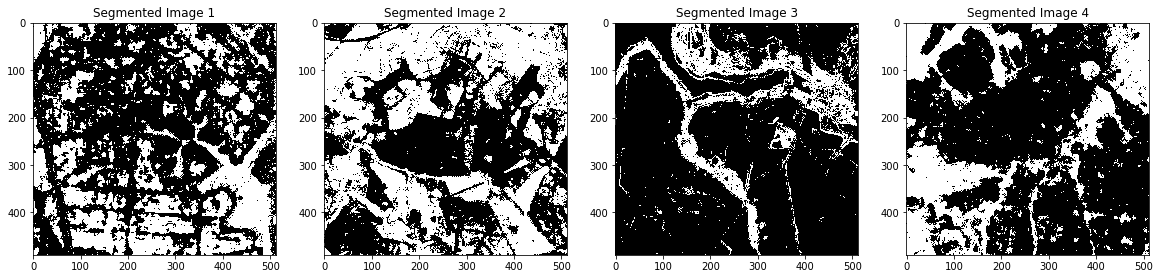

In [15]:
# classify
def cosine_classifier(features, clusters, comparison_vector, cosine_threshold):
    # prepare final segmentation output matrix:
    final_segment = np.zeros(features.shape[0])
    for c in np.unique(clusters):
        cluster_features = features[(clusters==c).flatten(),:]
        seg_avg = np.median(cluster_features,axis=0)
        # cosine similarity between cluster and comparison vector (forest)
        similarity = cosine_similarity([seg_avg], [comparison_vector])
        # classify
        if similarity>cosine_threshold:
            final_segment[(clusters==c).flatten()] = 1

    return(final_segment.reshape(clusters.shape))

final_seg1 = cosine_classifier(std_img1_features, clusters_std_1, forest_avg, cosine_threshold=0.32)
final_seg2 = cosine_classifier(std_img2_features, clusters_std_2, forest_avg, cosine_threshold=0.32)
final_seg3 = cosine_classifier(std_img3_features, clusters_std_3, forest_avg, cosine_threshold=0.32)
final_seg4 = cosine_classifier(std_img4_features, clusters_std_4, forest_avg, cosine_threshold=0.32)

plt.figure(figsize=(20,5))
plt.subplot(141); plt.imshow(final_seg1, cmap='gray'); plt.title('Segmented Image 1')
plt.subplot(142); plt.imshow(final_seg2, cmap='gray'); plt.title('Segmented Image 2')
plt.subplot(143); plt.imshow(final_seg3, cmap='gray'); plt.title('Segmented Image 3')
plt.subplot(144); plt.imshow(final_seg4, cmap='gray'); plt.title('Segmented Image 4')


### 4.2 Cosine classifier on raw data

In [16]:
# Using raw instead of standardized values:

# Average features for forest regions
cluster_features1 = img1_features[((clusters_std_1==4) | (clusters_std_1==2)).flatten(),:]
cluster_features2 = img2_features[(clusters_std_2==4).flatten(),:]
cluster_features3 = img3_features[(clusters_std_3==2).flatten(),:]
cluster_features4 = img4_features[(clusters_std_4==3).flatten(),:]

forest_features = pd.DataFrame([np.median(cluster_features1, axis=0),
                                np.median(cluster_features2,axis=0),
                                np.median(cluster_features3,axis=0),
                                #np.median(cluster_features4,axis=0),
                               ])

forest_avg = np.array(np.mean(forest_features, axis = 0))

Text(0.5, 1.0, 'Segmented Image 4')

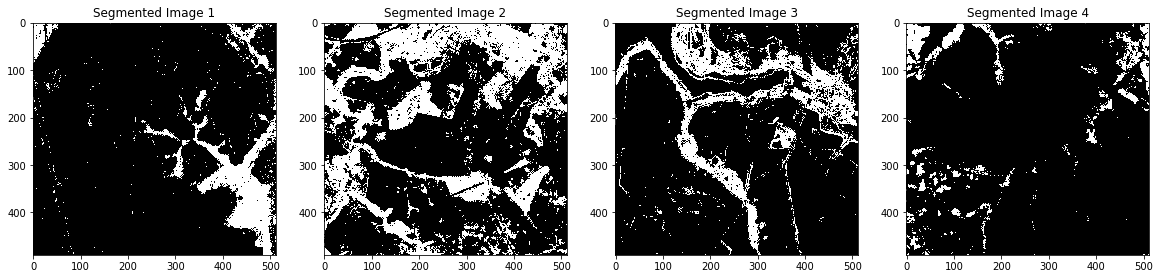

In [17]:
# Classify segments of the four images
final_seg1 = cosine_classifier(img1_features, clusters_std_1, forest_avg, cosine_threshold=0.994)
final_seg2 = cosine_classifier(img2_features, clusters_std_2, forest_avg, cosine_threshold=0.994)
final_seg3 = cosine_classifier(img3_features, clusters_std_3, forest_avg, cosine_threshold=0.994)
final_seg4 = cosine_classifier(img4_features, clusters_std_4, forest_avg, cosine_threshold=0.994)

plt.figure(figsize=(20,5))
plt.subplot(141); plt.imshow(final_seg1, cmap='gray'); plt.title('Segmented Image 1')
plt.subplot(142); plt.imshow(final_seg2, cmap='gray'); plt.title('Segmented Image 2')
plt.subplot(143); plt.imshow(final_seg3, cmap='gray'); plt.title('Segmented Image 3')
plt.subplot(144); plt.imshow(final_seg4, cmap='gray'); plt.title('Segmented Image 4')


In [18]:
# threshold classification
forest_avg_df = pd.DataFrame([forest_avg.round(2)])
forest_avg_df.columns = (['cive', 'wi', 'exg', 'exgr',
                                         'r', 'g', 'b', 'h', 's', 'v',
                                         'energy', 'contrast', 'correlation', 'homogeneity', 'entropy'])
forest_avg_df

#forest_features

,cive,wi,exg,exgr,r,g,b,h,s,v,energy,contrast,correlation,homogeneity,entropy
0,18.74,-0.06,0.06,0.04,0.17,0.21,0.23,0.5,0.41,0.25,0.05,75.95,0.43,0.33,4.81


## 5. Labelling 
I use mathematical morpheology to:
* remove sporadic regions in forest and non-forest areas
* generate an outline of forest regions
First, I fill holes in the segmented image, in order to remove noise and smooth forest areas. Opening followed by closing further helps smooth the segmented regions and remove sporadic regions from non-forest areas.

The final segmented image is eroded using a 7x7 cross structuring element. The erosion is subtracted from the segmentation, and the resulting outline is added to the original image.

Below, I visualize each step of this cleaning and outlining process for the sample image 2. The whole process is then applied to the final segmentations of all four images (see function *outline_overlay()*). 



Text(0.5, 1.0, 'Opening of Closing of Filled')

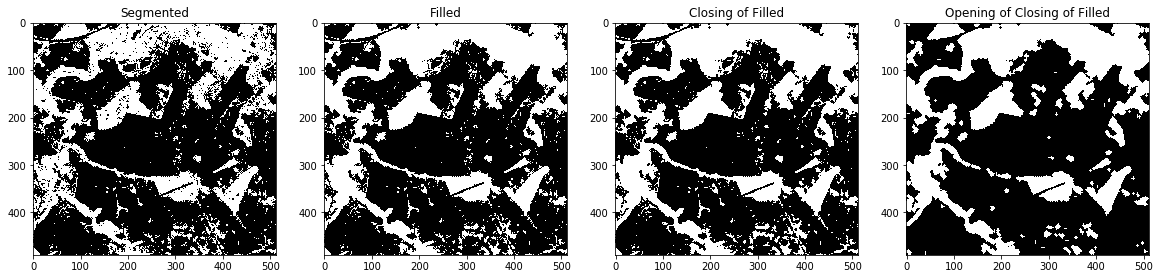

In [19]:
in_image = final_seg2
# structuring elements:
# 3x3 cross
struc_element = np.zeros((3,3))
struc_element[:,1]=1
struc_element[1,:]=1
# 7x7 cross
struc_element7 = np.zeros((7,7))
struc_element7[:,3]=1
struc_element7[3,:]=1

# fill holes
filled = ndimage.binary_fill_holes(input = in_image, structure = struc_element)

# opening/closing of double filled
closing_filled = ndimage.binary_closing(input = filled, structure = struc_element)
open_of_close_filled = ndimage.binary_opening(input = closing_filled, structure = struc_element7)


plt.figure(figsize=(20,5))
plt.subplot(141); plt.imshow(in_image, cmap='gray'); plt.title('Segmented')
plt.subplot(142); plt.imshow(filled, cmap='gray'); plt.title('Filled')
plt.subplot(143); plt.imshow(closing_filled, cmap='gray'); plt.title('Closing of Filled')
plt.subplot(144); plt.imshow(open_of_close_filled, cmap='gray'); plt.title('Opening of Closing of Filled')


Text(0.5, 1.0, 'Image 4')

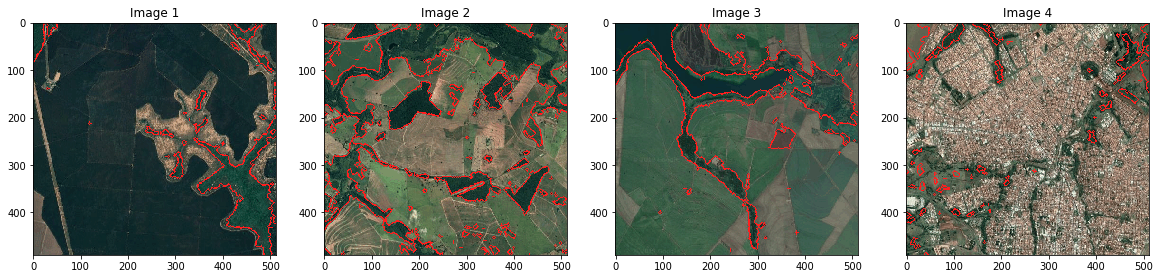

In [20]:
final1 = outline_overlay(final_seg1, img1)
final2 = outline_overlay(final_seg2, img2)
final3 = outline_overlay(final_seg3, img3)
final4 = outline_overlay(final_seg4, img4)


plt.figure(figsize=(20,5))
plt.subplot(141); plt.imshow(final1); plt.title('Image 1')
plt.subplot(142); plt.imshow(final2); plt.title('Image 2')
plt.subplot(143); plt.imshow(final3); plt.title('Image 3')
plt.subplot(144); plt.imshow(final4); plt.title('Image 4')

# B. Limitations
**Efficiency:** Instead of utilizing existing image processing libraries, this project has aimed to implement individual tasks from scratch, resulting in a fairly inefficient final pipeline. E.g. Haralick features are computed over a 7x7 neighborhood around each individual pixel, which is slow even using the *mahotas* library implementation. 

**Scope:** The approach does not distinguish between different types of tree-covered areas. For example, primary forest and soybean plantations differ not only by their tree density and tree diversity, but also by their ecological and economic impacts on our planet and society. Distinction between these types of forest areas is beyond the scope of this project. Existing studes exemplify how such a differentiation may be achieved, e.g. (Crowther et al, 2015).
Meant for illustrative purposes, this project makes use of current satellite imagery, not historical data, which restricts monitoring of forest area to present-day stocks and does not allow following flows over time.





# C. Results on Unseen Examples
The full pipeline of all these steps described above is applied to "unseen" images from the dataset using the function *full_pipeline()* below.

In [21]:
def full_pipeline(img_name, haralick_name, type):
    # read image
    img = imageio.imread('images/'+img_name)
    # remove google logo
    img = img[0:490,:,0:3]
    # generate features
    img_features = generate_features(img, haralick_name)
    # standardize features
    std_img_features = (img_features - np.mean(img_features, axis=0))/np.std(img_features, axis=0)
    # clustering
    clusters = kmeans(std_img_features, k=4, S=12, n_iterations=100).reshape((img1.shape[0], img1.shape[1]))
    # classify
    forest_avg_std = np.array([-0.61, 0.24, 0.61, 0.62, 
                           -0.87, -0.9, -0.86, 0.62, 0.52, -0.93, 
                           0.35, -0.11, 0.05, 0.4, -0.47])
    forest_avg_raw = np.array([18.74, -0.06, 0.06, 0.04, 
                               0.17, 0.21, 0.23, 0.5, 0.41, 0.25, 
                               0.05, 75.95, 0.43, 0.33, 4.81])
    if type=='raw':
        final_seg = cosine_classifier(img_features, clusters, forest_avg_raw, cosine_threshold=0.994)
    elif type=='std':
        final_seg = cosine_classifier(std_img_features, clusters, forest_avg_std, cosine_threshold=0.32)

    # cleaning and outline
    final = outline_overlay(final_seg, img)
    
    return(final)

Text(0.5, 1.0, 'Raw')

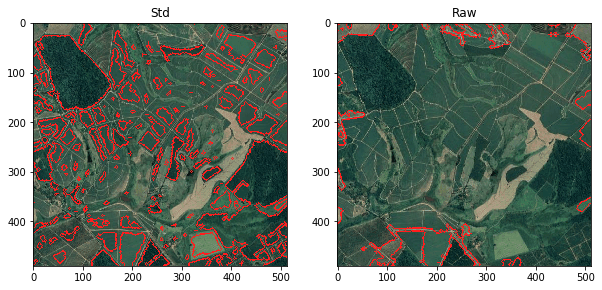

In [22]:
# available images:
images = listdir('images/')
# randomly select an image:
random.seed(2)
n = random.randint(0,20)
img_name = images[n]
haralick_name = 'haralick/'+img_name[:-4]+'_haralick.npy'
# apply full pipeline
out_example1_std = full_pipeline(img_name, haralick_name, type='std')
out_example1_raw = full_pipeline(img_name, haralick_name, type='raw')
# plot results
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(out_example1_std); plt.title('Std')
plt.subplot(122); plt.imshow(out_example1_raw); plt.title('Raw')

Text(0.5, 1.0, 'Raw')

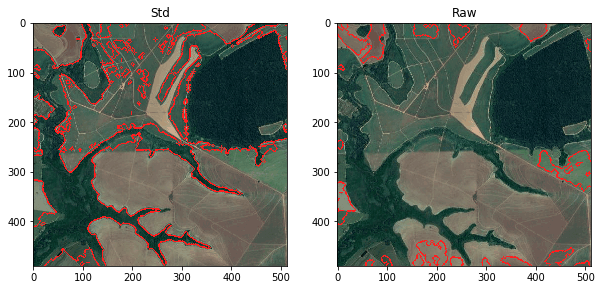

In [23]:
img_name = 'lat-21.47784611338061_long -48.90460588269983_map.png'
haralick_name = 'haralick/'+img_name[:-4]+'_haralick.npy'
# apply pipeline
out_example1_std = full_pipeline(img_name, haralick_name, type='std')
out_example1_raw = full_pipeline(img_name, haralick_name, type='raw')
# plot results:
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(out_example1_std); plt.title('Std')
plt.subplot(122); plt.imshow(out_example1_raw); plt.title('Raw')


# References

Crowther, T.W. et al, (2015). Mapping Tree Density at a Global Scale. Nature (525), 201–205

Giannini, M., Merola, P. and Allegrini, A.(2012). Texture Analysis for Urban Areas Classification in High Resolution Satellite Imagery. Applied Remote Sensing Journal. 2. 65-71. 


Gonzalez, R. and Woods, R. (2008). Digital Image Processing. Upper Saddle River, NJ: Pearson Education.


Haralick, R.M., Shanmugan, K. and Dinstein, I. (1973). Texturel features for image classification.- IEEE Transactions on Systems, Man and Cybernetics, Los Alamitos, v.SMC-3,n.6, pp. 610-621.


Kataoka, T., et al., (2003). Crop growth estimation system using machine vision. In: 2003 IEEE/ASME International Conference on Advanced Intelligent Mechatronics, 2003. AIM 2003. Proceedings. Presented at the 2003 IEEE/ASME International Conference on Advanced Intelligent Mechatronics, 2003. AIM 2003. Proceedings, pp. b1079–b1083, vol. 2.


MacQueen, J., 1967. Some methods for classification and analysis of multivariate observations. s.l., University of California Press, pp. 281-297.


Ponti, M., Nazare, T. and Thume, G. (2016).Image quantization as a dimensionality reduction procedure in color and texture feature extraction. Neurocomputing 173, 385–396.


Sebestyen, G., 1962. Decision making processes in pattern recognition. New York: Macmillan.


Torres-Sanchez, J. et al., (2014). Multi-temporal mapping of the vegetation fraction in early-season wheat fields using images from UAV. Computers and Electronics in Agriculture (103), 104–113.


Woebbecke, D.M., Meyer, G.E., Von Bargen, K., Mortensen, D.A., (1995). Color indices for weed identification under various soil, residue, and lighting conditions. Trans. ASAE 38, 259–269.